## Math behind A/B testing

key points:

1. controlled test to seek impacts

In [65]:
bcr = 0.1 # baseline conversion rate
d_hat = 0.02 # diff btwn the groups

#### Control Group(A) and Test Group(B)

In [66]:
# generate data
import scipy.stats as scs
import pandas as pd
import numpy as np

# create group column
N_A = 1000
N_B = 1000
bern_group = scs.bernoulli(N_A / (N_A + N_B))
group = bern_group.rvs(2000)
# creat converted column
converted = []
for _ in range(len(group)):
    if group[_] == 0:
        converted.append(scs.bernoulli(bcr).rvs()) # FAKE CLICK THROUGH RATE
    else:
        converted.append(scs.bernoulli(bcr + d_hat).rvs()) # FAKE CLICK THROUGH RATE WITH DIFF OF 0.02
data = pd.DataFrame(list(zip(converted, group)),columns =['converted', 'group'])

In [67]:
data['group'] = data['group'].apply(lambda x : 'A' if x == 0 else 'B')
data

,converted,group
0,0,A
1,0,B
2,0,A
3,0,B
4,0,A
...,...,...
1995,0,B
1996,0,B
1997,0,B
1998,0,A


In [68]:
summary = data.pivot_table(values = 'converted', index = 'group', aggfunc = np.sum)
summary["total"] = [data.group.value_counts()['A'],data.group.value_counts()['B']]
summary["rate"] = summary["converted"]/summary["total"]

In [69]:
summary

,converted,total,rate
group,,,
A,99,992,0.099798
B,128,1008,0.126984


In [70]:
# calculate statistics

Ppool = (summary.converted.A + summary.converted.B) / (summary.total.A + summary.total.B)
SE = np.sqrt(Ppool * (1 - Ppool) * (1 / summary.total.A + 1 / summary.total.B))
conf = 1.96 * SE # 95% based on Gaussian distribution
conf

0.027804959561374607

In [71]:
- summary.rate.diff()

group
A         NaN
B   -0.027186
Name: rate, dtype: float64

\< 0.02665.. , statistically NOT significant

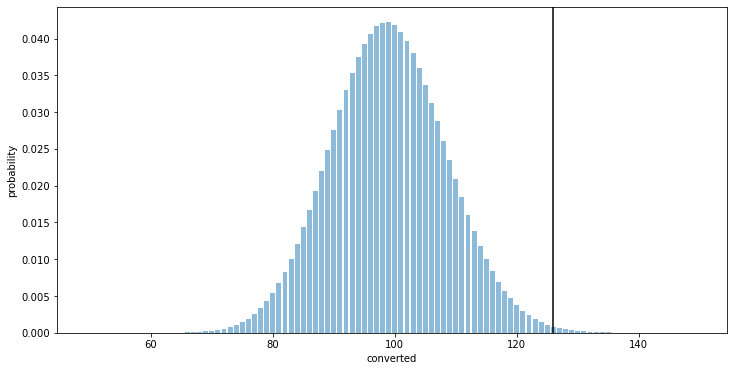

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,6))
x = np.linspace(summary.converted.A-49,summary.converted.A+50,100)
y = scs.binom(summary.total.A,summary.rate.A).pmf(x)
ax.bar(x,y,alpha = 0.5)
ax.axvline(summary.rate.B * summary.total.A, c='k', linestyle='-')
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

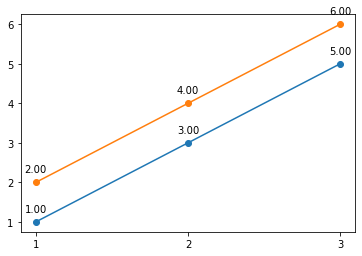

In [73]:
import numpy as np
import matplotlib.pyplot as plt
x = [1, 2, 3]
y = np.array([[1, 2], [3, 4], [5, 6]])
plt.plot(x, y,'o-');
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
for _ in range(y.shape[1]):
    for xs,ys in zip(x,y[:,_]):
        label = "{:.2f}".format(ys)
        plt.annotate(label, # this is the text
                     (xs,ys), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


In [74]:
sum = 0
ls = [x**2 for x in range(10)]
print(np.sqrt(np.sum(ls)))

16.881943016134134


In [75]:
import tqdm
import random

for i in tqdm.tqdm(range(100)):
    # do something slow
    _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


In [77]:
with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)

            t.set_description(f"{len(primes)} primes")   

4 primes: 100%|██████████| 7/7 [00:00<00:00, 983.29it/s]


In [2]:
#!pip install PyMySQL


In [11]:
import pymysql

db = pymysql.connect(host = "localhost",user = "root",password = 'archie-0714',database = 'sakila')

In [13]:
with db.cursor() as cursor:   
    sql = "select VERSION()"
    cursor.execute(sql)
    data = cursor.fetchone()[0]
    print(data)

8.0.25
